In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import tensorflow.keras as Keras
from PIL import Image

from warnings import filterwarnings
filterwarnings("ignore")

In [3]:
model_path = "models/2"
cam_path = "grad_cam/2"

INPUT_SIZE = (256, 256)

In [4]:
model = Keras.models.load_model(model_path)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.output_shape, layer.trainable)

In [5]:
last_conv_layer_name = "conv5_block3_out"

In [6]:
model.inputs, model.get_layer(last_conv_layer_name)

([<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>],
 <keras.layers.core.activation.Activation at 0x165d1fb9db0>)

In [7]:
def get_img_array(img_path, img_size):
    img = Keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_arr = Keras.preprocessing.image.img_to_array(img)
    img_batched = np.expand_dims(img_arr, axis=0)
    return img_batched

In [8]:
def make_gradcam_heatmap(img_arr, model, last_conv_layer_name, pred_idx=None):
    grad_model = Keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_arr)
    
        if pred_idx is None:
            pred_idx = tf.argmax(preds[0])
        class_channel = preds[:, pred_idx]
    
    gradients = tape.gradient(class_channel, last_conv_layer_output)
    
    pooled_grads = tf.reduce_mean(gradients, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [9]:
def save_and_get_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = Keras.preprocessing.image.load_img(img_path)
    img = Keras.preprocessing.image.img_to_array(img)
    
    heatmap = np.uint8(255 * heatmap)
    
    jet = cm.get_cmap("jet")
    
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    jet_heatmap = Keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = Keras.preprocessing.image.img_to_array(jet_heatmap)
    
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = Keras.preprocessing.image.array_to_img(superimposed_img)
    
    superimposed_img.save(cam_path)
    
    return superimposed_img

In [10]:
def view_cam(img_path, alpha=0.5):
    img_array = get_img_array(img_path, INPUT_SIZE)
    class_names = pd.read_csv("assets/class_names.csv")["labels"].tolist()
    pred = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    if not os.path.exists(cam_path):
        os.mkdir(cam_path)
    cam_n = max([int(i.split(".")[0]) for i in os.listdir(cam_path)], default=0) + 1
    
    cam_img = save_and_get_gradcam(img_path, heatmap, cam_path=os.path.join(cam_path, f"{cam_n}.jpg"), alpha=alpha)
    
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(img_array).astype("uint8"))
    plt.title("Input image")
    plt.axis("off");
    
    plt.subplot(1, 2, 2)
    plt.imshow(cam_img)
    plt.title("Grad cam result")
    plt.axis("off");
    print(f"Predicted: {class_names[np.argmax(pred[0])]}")

1/1 [==============================] - 0s 31ms/step
Predicted: Tomato_Early_blight


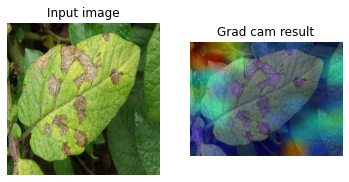

In [22]:
img_path = "test-images/poeb1.jpg"

view_cam(img_path, alpha=0.8)